In [1]:
import pandas as pd
import json

test_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/raw/test.csv'
train_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/raw/train.csv'
products_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/raw/products.pkl'
user_details_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/raw/format_user_details.json'

# User details

## Cargamos Json

### info

In [2]:
# Cargar el JSON
with open(user_details_path, 'r') as file:
    users_data = json.load(file)

# Convertir el JSON a un DataFrame
users_df = pd.json_normalize(users_data)

# Visualizar las primeras filas y la estructura
print(users_df.info())
print(users_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557006 entries, 0 to 557005
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_id         557006 non-null  int64 
 1   values.country  557006 non-null  object
 2   values.R        557006 non-null  object
 3   values.F        557006 non-null  object
 4   values.M        557006 non-null  object
dtypes: int64(1), object(4)
memory usage: 21.2+ MB
None
   user_id values.country values.R values.F              values.M
0   430096           [25]     [18]      [6]  [18.197777777777777]
1   134018           [25]     [66]     [32]   [38.86882352941177]
2    53750           [25]      [2]     [64]   [38.54178082191778]
3   180665           [25]     [22]     [22]  [43.407916666666665]
4   134209           [25]      [7]      [2]               [43.46]


### Procesar las columnas y desanidar

In [3]:
# Desanidar las columnas, extrayendo el primer elemento si es una lista de un solo valor
for col in ['values.country', 'values.R', 'values.F', 'values.M']:
    users_df[col] = users_df[col].apply(lambda x: x[0] if len(x) == 1 else x)

# Verificar columnas con múltiples valores
multiple_countries = users_df[users_df['values.country'].apply(lambda x: isinstance(x, list))]

print(f"Registros con múltiples valores en 'values.country': {len(multiple_countries)}")
print(multiple_countries.head())


Registros con múltiples valores en 'values.country': 17153
    user_id values.country   values.R values.F  \
9    134208       [34, 25]  [819, 50]   [0, 5]   
13   180663       [25, 20]  [113, 23]  [36, 2]   
21    40363       [25, 20]  [76, 323]  [11, 1]   
28    37321        [3, 25]  [337, 13]  [13, 3]   
44   180658       [25, 46]  [17, 617]  [38, 1]   

                                    values.M  
9                   [0.0, 69.86599999999999]  
13   [37.486000000000004, 4.993333333333333]  
21               [26.429285714285708, 17.99]  
28  [25.574999999999996, 32.946666666666665]  
44                 [33.67219512195123, 45.9]  


### Expandir los registros duplicándolos

Duplicaremos las filas para que cada combinación de country, R, F, y M se convierta en un registro único.

In [4]:
# Expandir registros con múltiples valores
expanded_users = []

for _, row in users_df.iterrows():
    # Asegurar que todos los valores sean listas
    countries = row['values.country'] if isinstance(row['values.country'], list) else [row['values.country']]
    recencies = row['values.R'] if isinstance(row['values.R'], list) else [row['values.R']]
    frequencies = row['values.F'] if isinstance(row['values.F'], list) else [row['values.F']]
    monetaries = row['values.M'] if isinstance(row['values.M'], list) else [row['values.M']]
    
    # Crear nuevas filas para cada combinación
    for country, r, f, m in zip(countries, recencies, frequencies, monetaries):
        expanded_users.append({
            'user_id': row['user_id'],
            'country': country,
            'R': r,
            'F': f,
            'M': m
        })

# Crear nuevo DataFrame con registros expandidos
expanded_users_df = pd.DataFrame(expanded_users)

# Verificar el nuevo DataFrame
print(expanded_users_df.info())
print(expanded_users_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577494 entries, 0 to 577493
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  577494 non-null  int64  
 1   country  577494 non-null  int64  
 2   R        577494 non-null  int64  
 3   F        577494 non-null  int64  
 4   M        577494 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 22.0 MB
None
   user_id  country   R   F          M
0   430096       25  18   6  18.197778
1   134018       25  66  32  38.868824
2    53750       25   2  64  38.541781
3   180665       25  22  22  43.407917
4   134209       25   7   2  43.460000


## Análisis inicial

In [5]:
# Estadísticas básicas
print(expanded_users_df.describe())

# Valores únicos por columna
for col in expanded_users_df.columns:
    print(f"Valores únicos en '{col}': {expanded_users_df[col].nunique()}")

# Valores nulos
print("\nValores nulos por columna:")
print(expanded_users_df.isnull().sum())


             user_id        country              R              F  \
count  577494.000000  577494.000000  577494.000000  577494.000000   
mean   278298.974377      25.247495      69.945702      36.632408   
std    160779.256697       3.945214     142.504278      58.701908   
min         1.000000       1.000000       0.000000       0.000000   
25%    139100.250000      25.000000       5.000000       8.000000   
50%    278160.500000      25.000000      19.000000      22.000000   
75%    417476.750000      25.000000      63.000000      47.000000   
max    557006.000000      93.000000    1095.000000   10754.000000   

                  M  
count  5.774940e+05  
mean   8.942316e+02  
std    6.821667e+04  
min    0.000000e+00  
25%    2.770545e+01  
50%    3.823774e+01  
75%    5.253000e+01  
max    2.898200e+07  
Valores únicos en 'user_id': 557006
Valores únicos en 'country': 93
Valores únicos en 'R': 1096
Valores únicos en 'F': 915
Valores únicos en 'M': 480544

Valores nulos por columna:

### Inspeccionar valores atípicos en M


In [6]:
# Identificar outliers en M
import numpy as np

# Calcular percentiles
q1, q3 = np.percentile(expanded_users_df['M'], [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrar valores extremos
outliers = expanded_users_df[(expanded_users_df['M'] < lower_bound) | (expanded_users_df['M'] > upper_bound)]
print(f"Registros con valores atípicos en 'M': {len(outliers)}")
print(outliers.head())


Registros con valores atípicos en 'M': 30824
    user_id  country    R    F             M
5     40366       25   18  126    105.764692
44    40361       25   22   13     99.561538
53   374283       25   29    2    126.525000
59    53751       46  240    1    157.450000
60    53751       68  548    1  18580.000000


#### Aplicar transformación logarítmica a M
Usaremos la transformación logarítmica en M para mitigar el impacto de los valores extremos.

In [7]:
# Transformación logarítmica en 'M'
expanded_users_df['M_log'] = np.log1p(expanded_users_df['M'])

# Verificar la transformación
print("\nDistribución de 'M' después de transformación logarítmica:")
print(expanded_users_df['M_log'].describe())



Distribución de 'M' después de transformación logarítmica:
count    577494.000000
mean          3.682476
std           0.722278
min           0.000000
25%           3.357087
50%           3.669639
75%           3.980242
max          17.182186
Name: M_log, dtype: float64


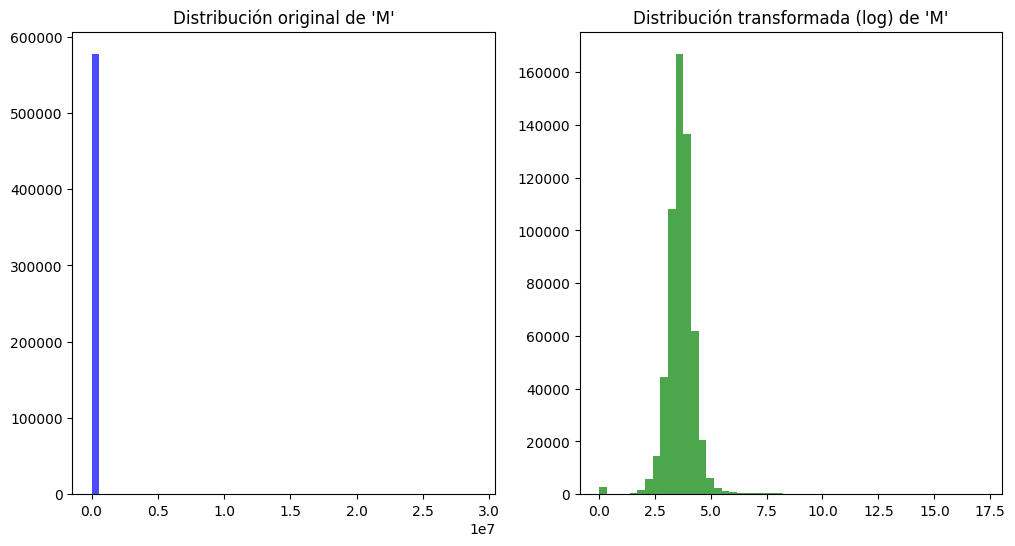

In [8]:
# Revisión de la distribución transformada

import matplotlib.pyplot as plt

# Histograma antes y después de la transformación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(expanded_users_df['M'], bins=50, color='blue', alpha=0.7)
plt.title("Distribución original de 'M'")
plt.subplot(1, 2, 2)
plt.hist(expanded_users_df['M_log'], bins=50, color='green', alpha=0.7)
plt.title("Distribución transformada (log) de 'M'")
plt.show()

### Optimización de Tipos de Datos

In [9]:
# Sustituir la columna original 'M' por 'M_log' y renombrarla a 'M'
optimized_users_df = expanded_users_df.drop(columns=['M']).rename(columns={'M_log': 'M'})

# Optimizar tipos de datos
optimized_users_df['user_id'] = optimized_users_df['user_id'].astype('int32')
optimized_users_df['country'] = optimized_users_df['country'].astype('int8')
optimized_users_df['R'] = optimized_users_df['R'].astype('int16')
optimized_users_df['F'] = optimized_users_df['F'].astype('int16')
optimized_users_df['M'] = optimized_users_df['M'].astype('float32')

# Verificar el resultado
print("\nUso de memoria después de la optimización:")
print(optimized_users_df.info())

optimized_users_df = expanded_users_df.drop(columns=['M']).rename(columns={'M_log': 'M'})

# Optimizar tipos de datos
optimized_users_df['user_id'] = optimized_users_df['user_id'].astype('int32')
optimized_users_df['country'] = optimized_users_df['country'].astype('int8')
optimized_users_df['R'] = optimized_users_df['R'].astype('int16')
optimized_users_df['F'] = optimized_users_df['F'].astype('int16')
optimized_users_df['M'] = optimized_users_df['M'].astype('float32')

# Verificar el resultado
print("\nUso de memoria después de la optimización:")
print(optimized_users_df.info())


Uso de memoria después de la optimización:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577494 entries, 0 to 577493
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  577494 non-null  int32  
 1   country  577494 non-null  int8   
 2   R        577494 non-null  int16  
 3   F        577494 non-null  int16  
 4   M        577494 non-null  float32
dtypes: float32(1), int16(2), int32(1), int8(1)
memory usage: 7.2 MB
None

Uso de memoria después de la optimización:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577494 entries, 0 to 577493
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  577494 non-null  int32  
 1   country  577494 non-null  int8   
 2   R        577494 non-null  int16  
 3   F        577494 non-null  int16  
 4   M        577494 non-null  float32
dtypes: float32(1), int16(2), int32(1), int8(1)
memory usage: 7.2 MB
Non

In [10]:
optimized_users_df.head()

,user_id,country,R,F,M
0,430096,25,18,6,2.954795
1,134018,25,66,32,3.685595
2,53750,25,2,64,3.677358
3,180665,25,22,22,3.793418
4,134209,25,7,2,3.794590


In [11]:
optimized_users_df.describe()

,user_id,country,R,F,M
count,577494.000000,577494.000000,577494.000000,577494.000000,577494.000000
mean,278298.974377,25.247495,69.945702,36.632408,3.682476
std,160779.256697,3.945214,142.504278,58.701908,0.722278
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,139100.250000,25.000000,5.000000,8.000000,3.357087
50%,278160.500000,25.000000,19.000000,22.000000,3.669639
75%,417476.750000,25.000000,63.000000,47.000000,3.980242
max,557006.000000,93.000000,1095.000000,10754.000000,17.182186


## Analisis descriptivo

### Distribución de la variables

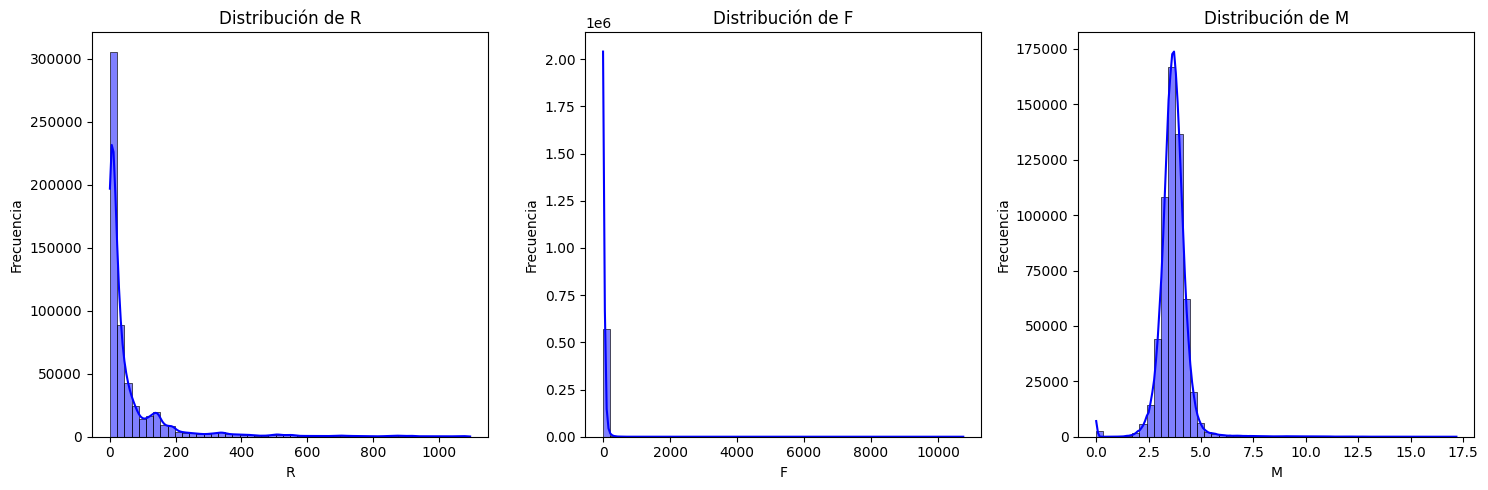

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables clave
variables = ['R', 'F', 'M']

# Crear gráficos de distribución
plt.figure(figsize=(15, 5))
for i, var in enumerate(variables, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=optimized_users_df, x=var, kde=True, bins=50, color='blue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

### Transformar R y F
Ambas tienen distribuciones sesgadas y esto podría impactar negativamente en los modelos de machine learning

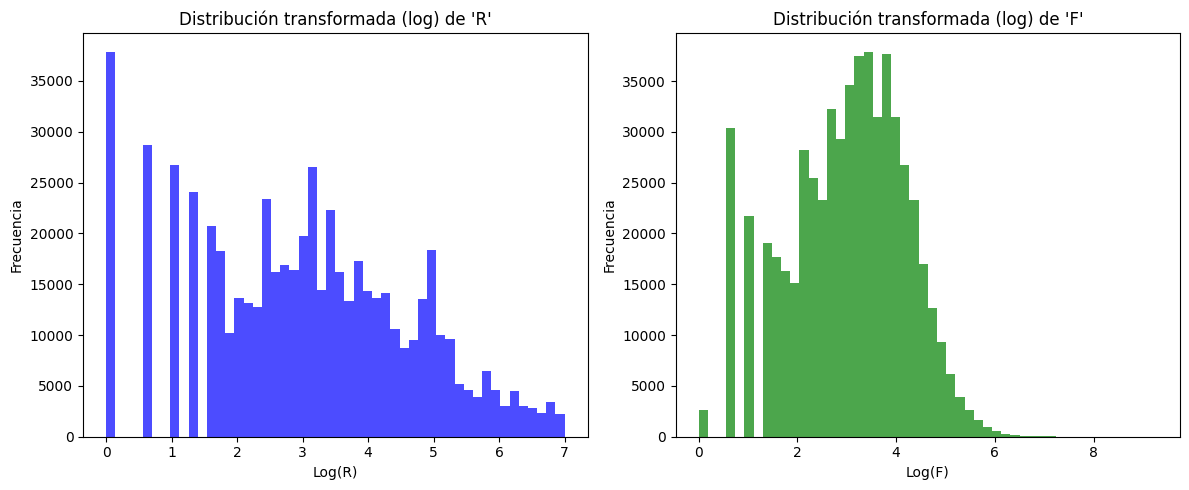

Estadísticas después de la transformación logarítmica:
               R_log          F_log
count  577494.000000  577494.000000
mean        2.996120       3.006840
std         1.649086       1.174892
min         0.000000       0.000000
25%         1.791759       2.197225
50%         2.995732       3.135494
75%         4.158883       3.871201
max         6.999423       9.283126


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Transformación logarítmica de R y F en optimized_users_df
optimized_users_df['R_log'] = np.log1p(optimized_users_df['R'])
optimized_users_df['F_log'] = np.log1p(optimized_users_df['F'])

# Visualización de las distribuciones transformadas
plt.figure(figsize=(12, 5))

# Distribución de R
plt.subplot(1, 2, 1)
plt.hist(optimized_users_df['R_log'], bins=50, color='blue', alpha=0.7)
plt.title("Distribución transformada (log) de 'R'")
plt.xlabel('Log(R)')
plt.ylabel('Frecuencia')

# Distribución de F
plt.subplot(1, 2, 2)
plt.hist(optimized_users_df['F_log'], bins=50, color='green', alpha=0.7)
plt.title("Distribución transformada (log) de 'F'")
plt.xlabel('Log(F)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Verificar estadísticas después de la transformación
print("Estadísticas después de la transformación logarítmica:")
print(optimized_users_df[['R_log', 'F_log']].describe())


### Normalizar/escalar

- Utilizaremos Min-Max Scaling para escalar las variables R_log, F_log, y M a un rango entre 0 y 1. 
- Suele ser útil para garantizar que todas las características tengan un peso similar en los algoritmos de aprendizaje automático

Estadísticas después de la normalización:
        R_log_scaled   F_log_scaled       M_scaled
count  577494.000000  577494.000000  577494.000000
mean        0.428053       0.323904       0.214319
std         0.235603       0.126562       0.042036
min         0.000000       0.000000       0.000000
25%         0.255987       0.236690       0.195382
50%         0.427997       0.337763       0.213572
75%         0.594175       0.417015       0.231649
max         1.000000       1.000000       1.000000


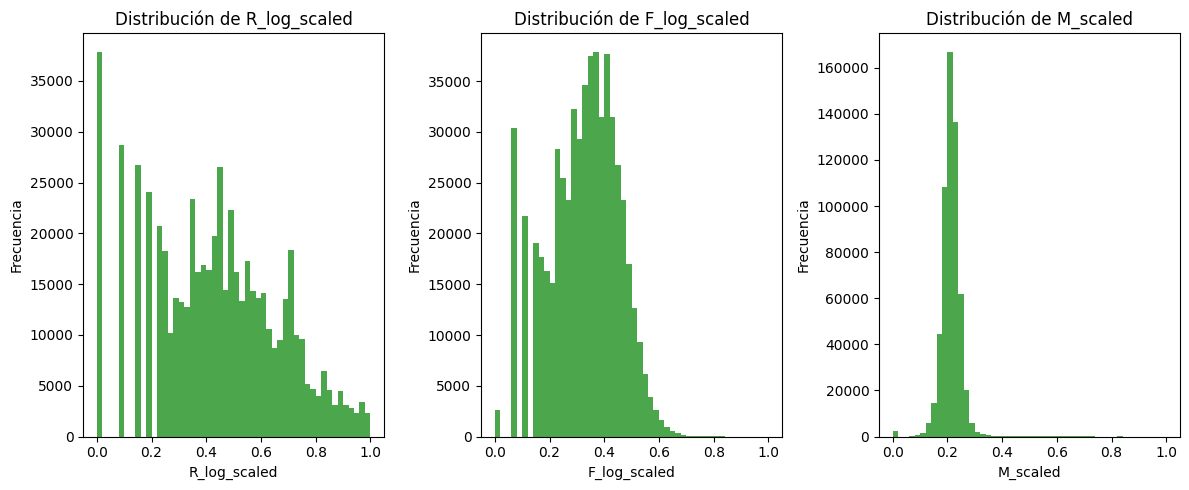

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Crear el escalador Min-Max
scaler = MinMaxScaler()

# Escalar las columnas seleccionadas
columns_to_scale = ['R_log', 'F_log', 'M']
scaled_values = scaler.fit_transform(optimized_users_df[columns_to_scale])

# Añadir las columnas escaladas al DataFrame
for i, column in enumerate(columns_to_scale):
    optimized_users_df[f'{column}_scaled'] = scaled_values[:, i]

# Verificar las estadísticas después de la normalización
scaled_stats = optimized_users_df[[f'{col}_scaled' for col in columns_to_scale]].describe()
print("Estadísticas después de la normalización:")
print(scaled_stats)

# Visualizar las distribuciones normalizadas
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

for i, column in enumerate(columns_to_scale):
    plt.subplot(1, len(columns_to_scale), i+1)
    plt.hist(optimized_users_df[f'{column}_scaled'], bins=50, color='green', alpha=0.7)
    plt.title(f'Distribución de {column}_scaled')
    plt.xlabel(f'{column}_scaled')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


In [17]:
print(optimized_users_df.info())
print(optimized_users_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577494 entries, 0 to 577493
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       577494 non-null  int32  
 1   country       577494 non-null  int8   
 2   R             577494 non-null  int16  
 3   F             577494 non-null  int16  
 4   M             577494 non-null  float32
 5   R_log         577494 non-null  float32
 6   F_log         577494 non-null  float32
 7   R_log_scaled  577494 non-null  float32
 8   F_log_scaled  577494 non-null  float32
 9   M_scaled      577494 non-null  float32
dtypes: float32(6), int16(2), int32(1), int8(1)
memory usage: 18.2 MB
None
   user_id  country   R   F         M     R_log     F_log  R_log_scaled  \
0   430096       25  18   6  2.954795  2.944439  1.945910      0.420669   
1   134018       25  66  32  3.685595  4.204693  3.496508      0.600720   
2    53750       25   2  64  3.677358  1.098612  4.174387    

In [18]:
# Eliminar columnas intermedias y originales
columns_to_drop = ['R', 'F', 'M', 'R_log', 'F_log']
optimized_users_df = optimized_users_df.drop(columns=columns_to_drop)

# Renombrar las columnas normalizadas
optimized_users_df.rename(columns={
    'R_log_scaled': 'R',
    'F_log_scaled': 'F',
    'M_scaled': 'M'
}, inplace=True)

# Verificar la estructura final del dataset
print(optimized_users_df.info())
print(optimized_users_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577494 entries, 0 to 577493
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  577494 non-null  int32  
 1   country  577494 non-null  int8   
 2   R        577494 non-null  float32
 3   F        577494 non-null  float32
 4   M        577494 non-null  float32
dtypes: float32(3), int32(1), int8(1)
memory usage: 9.4 MB
None
   user_id  country         R         F         M
0   430096       25  0.420669  0.209618  0.171968
1   134018       25  0.600720  0.376652  0.214501
2    53750       25  0.156958  0.449675  0.214022
3   180665       25  0.447965  0.337763  0.220776
4   134209       25  0.297088  0.118345  0.220844


### Distribución por país

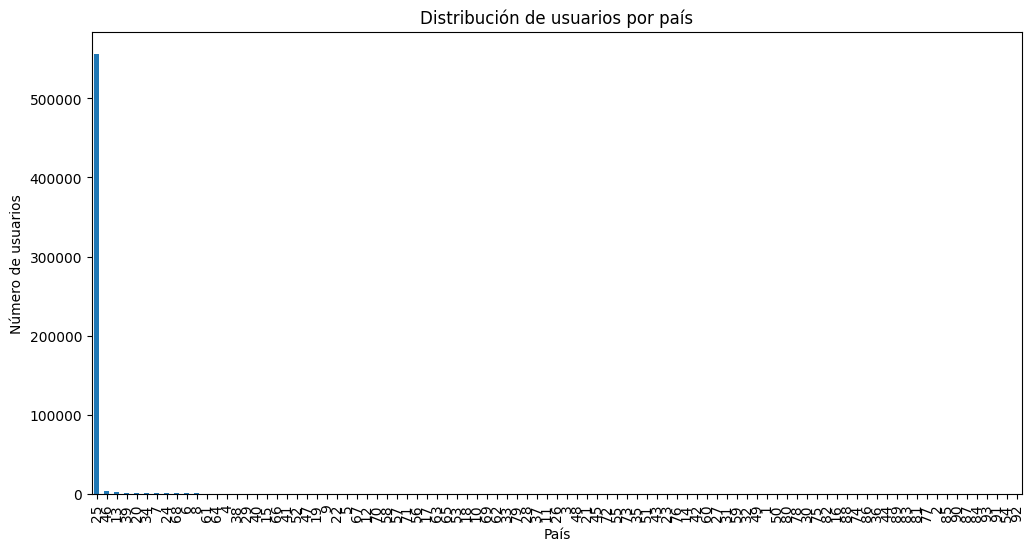

In [19]:
# Distribución de usuarios por país
country_counts = optimized_users_df['country'].value_counts()

# Visualización
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar')
plt.title('Distribución de usuarios por país')
plt.xlabel('País')
plt.ylabel('Número de usuarios')
plt.show()


### Correlaciones entre R, F y M

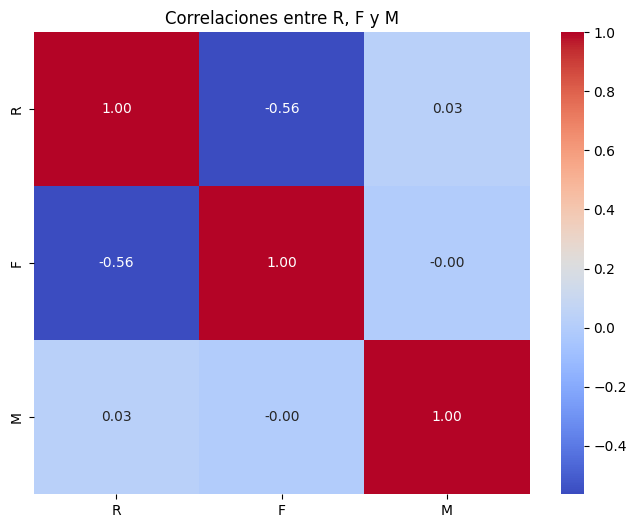

In [20]:
# Matriz de correlación
correlation_matrix = optimized_users_df[['R', 'F', 'M']].corr()

# Visualización de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlaciones entre R, F y M')
plt.show()


### Segmentación básica con k-means

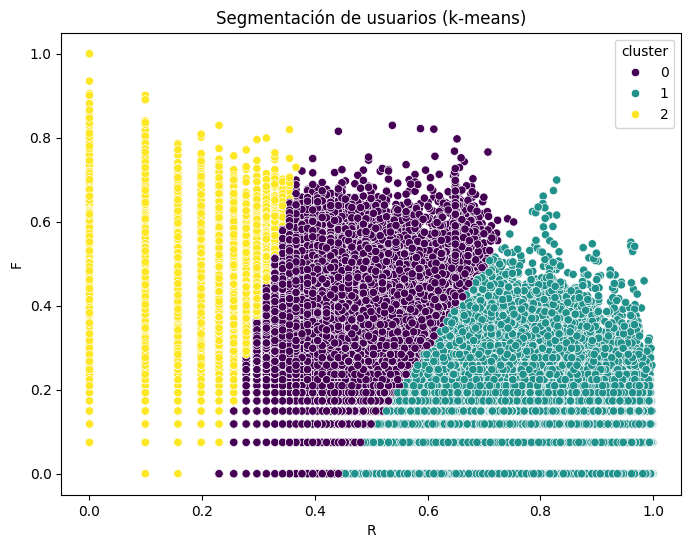

In [21]:
from sklearn.cluster import KMeans

# Aplicar k-means (3 clusters como ejemplo)
kmeans = KMeans(n_clusters=3, random_state=42)
optimized_users_df['cluster'] = kmeans.fit_predict(optimized_users_df[['R', 'F', 'M']])

# Visualización en 2D (usando R y F como ejemplo)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=optimized_users_df, x='R', y='F', hue='cluster', palette='viridis')
plt.title('Segmentación de usuarios (k-means)')
plt.show()


### Distribución de R, F, M por país

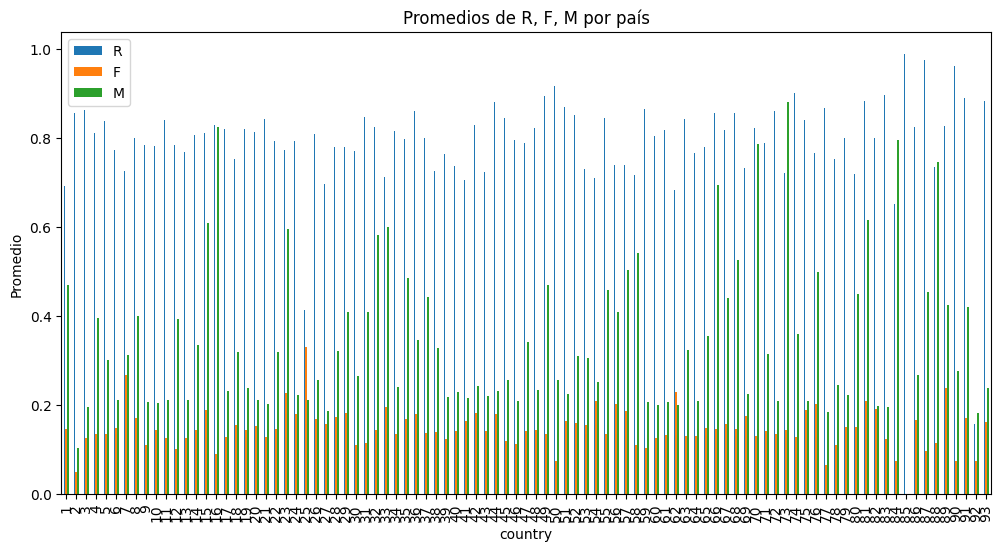

In [22]:
# Resumen estadístico por país
country_summary = optimized_users_df.groupby('country')[['R', 'F', 'M']].mean()

# Visualización
country_summary.plot(kind='bar', figsize=(12, 6))
plt.title('Promedios de R, F, M por país')
plt.ylabel('Promedio')
plt.show()


### Identificación de "mejores" usuarios

In [23]:
# Identificar usuarios del top 1% en F y M
top_users = optimized_users_df[(optimized_users_df['F'] > optimized_users_df['F'].quantile(0.99)) &
                                (optimized_users_df['M'] > optimized_users_df['M'].quantile(0.99))]

print(f"Usuarios en el top 1%: {len(top_users)}")
print(top_users)


Usuarios en el top 1%: 88
        user_id  country         R         F         M  cluster
2535     268831        7  0.690954  0.618304  0.353993        0
3629     374697        7  0.000000  0.622715  0.352432        2
4763     409308        7  0.434968  0.717078  0.362213        0
5711     193222        7  0.404778  0.646753  0.339700        0
6470     429657        7  0.676656  0.609277  0.352840        0
...         ...      ...       ...       ...       ...      ...
384034   138581        7  0.377039  0.720753  0.334512        0
425753   459147       25  0.000000  0.593484  0.345345        2
427541   485612        7  0.530554  0.724048  0.328939        0
442473   331824        7  0.600720  0.605832  0.347622        0
535043    10926       25  0.198058  0.603075  0.377971        2

[88 rows x 6 columns]


### Distribución de clústeres por país

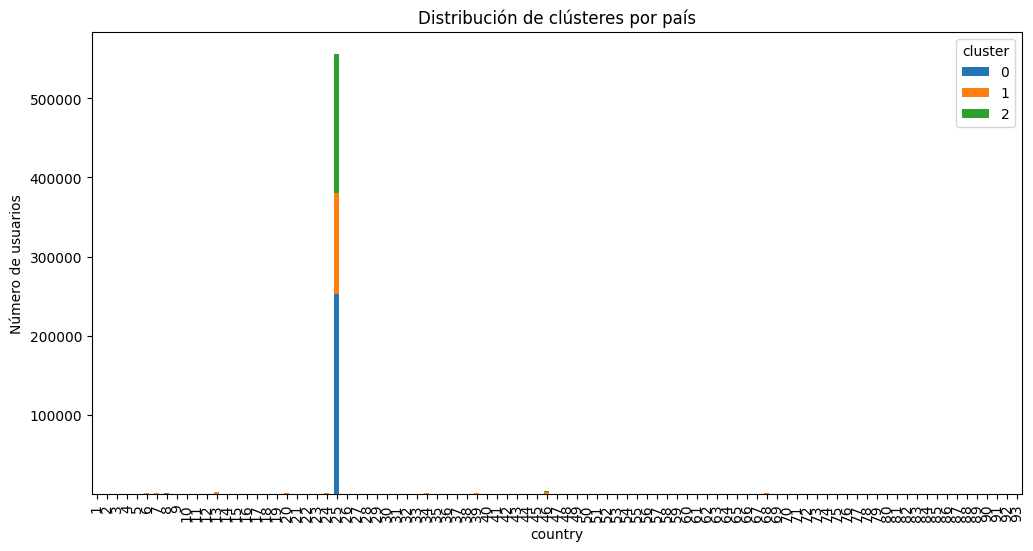

In [24]:
# Distribución de clústeres por país
cluster_distribution = optimized_users_df.groupby(['country', 'cluster']).size().unstack()

# Visualización
cluster_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribución de clústeres por país')
plt.ylabel('Número de usuarios')
plt.show()


### Revisión de usuarios del top 1%

In [25]:
import pandas as pd

# Calcular el percentil 99 para las variables R, F, y M
percentile_99_R = optimized_users_df['R'].quantile(0.99)
percentile_99_F = optimized_users_df['F'].quantile(0.99)
percentile_99_M = optimized_users_df['M'].quantile(0.99)

# Filtrar usuarios en el top 1% para cada métrica
top_1_percent_users = optimized_users_df[
    (optimized_users_df['R'] >= percentile_99_R) |
    (optimized_users_df['F'] >= percentile_99_F) |
    (optimized_users_df['M'] >= percentile_99_M)
]

# Filtrar usuarios fuera del top 1% (resto de los usuarios)
rest_of_users = optimized_users_df[
    (optimized_users_df['R'] < percentile_99_R) &
    (optimized_users_df['F'] < percentile_99_F) &
    (optimized_users_df['M'] < percentile_99_M)
]

# Estadísticas descriptivas para el top 1% de usuarios
top_1_stats = top_1_percent_users[['R', 'F', 'M']].describe()

# Estadísticas descriptivas para el resto de los usuarios
rest_stats = rest_of_users[['R', 'F', 'M']].describe()

# Comparación entre el top 1% y el resto
comparison_stats = pd.concat([top_1_stats, rest_stats], keys=['Top 1%', 'Resto'])

# Mostrar resultados
print("Estadísticas descriptivas para el Top 1% y el resto de los usuarios:")
print(comparison_stats)

# Cantidad de usuarios en cada grupo
print(f"\nUsuarios en el top 1%: {len(top_1_percent_users)}")
print(f"Usuarios en el resto: {len(rest_of_users)}")


Estadísticas descriptivas para el Top 1% y el resto de los usuarios:
                          R              F              M
Top 1% count   16386.000000   16386.000000   16386.000000
       mean        0.619934       0.313325       0.287364
       std         0.370837       0.246254       0.146967
       min         0.000000       0.000000       0.000000
       25%         0.229939       0.074667       0.196802
       50%         0.755529       0.193013       0.238508
       75%         0.968315       0.598594       0.352432
       max         1.000000       1.000000       1.000000
Resto  count  561108.000000  561108.000000  561108.000000
       mean        0.422449       0.324213       0.212186
       std         0.228051       0.121291       0.032056
       min         0.000000       0.000000       0.000000
       25%         0.255987       0.236690       0.195361
       50%         0.420669       0.337763       0.213264
       75%         0.584955       0.414747       0.230947
   

#### Comparar gráficamente las distribuciones de R, F y M entre el top 1% y el resto de los usuarios:

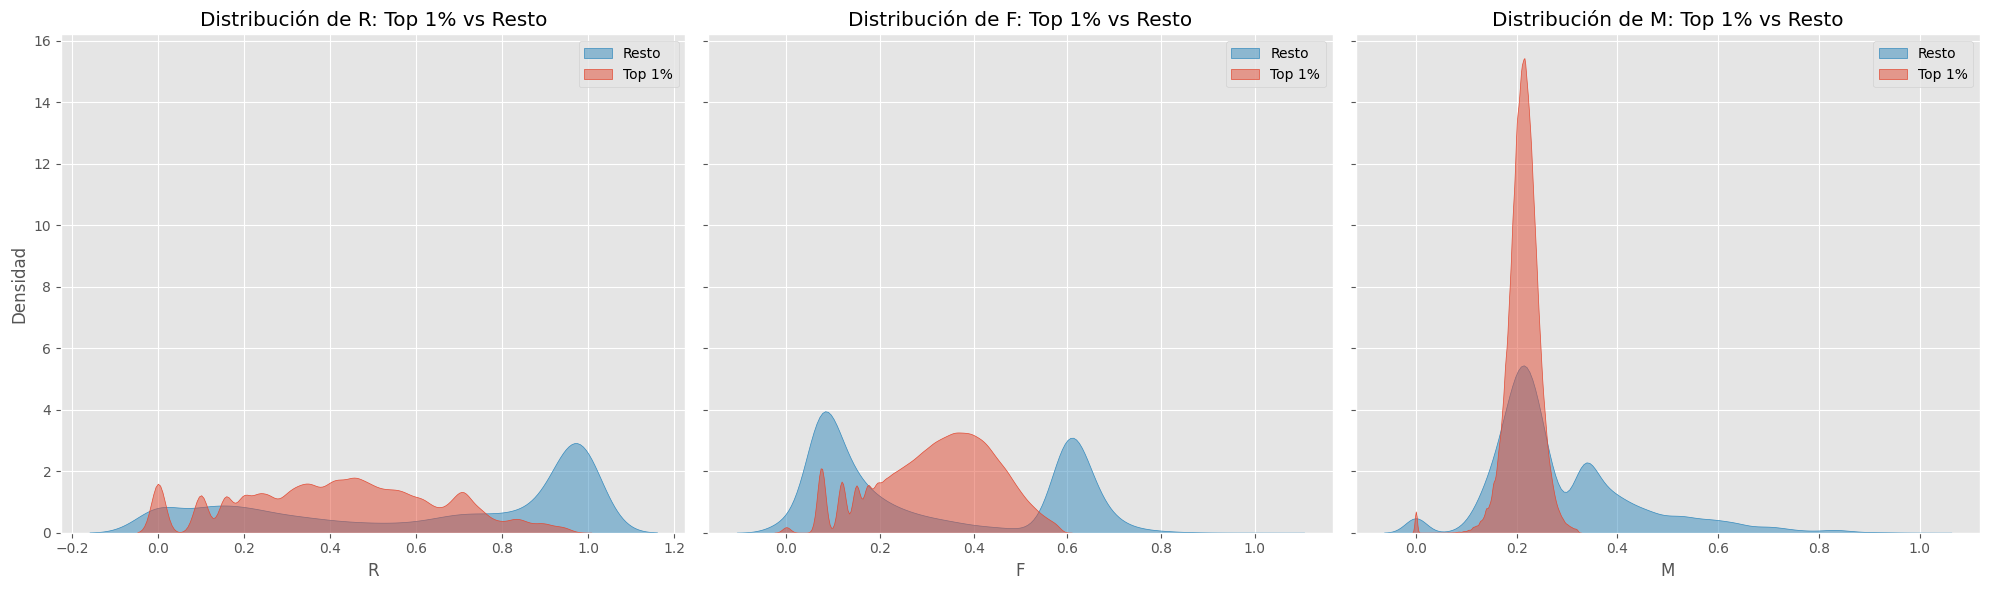

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un indicador para el Top 1%
optimized_users_df['is_top_1'] = optimized_users_df.index.isin(top_1_percent_users.index)

# Configurar el estilo de los gráficos
plt.style.use('ggplot')

# Variables a analizar
variables = ['R', 'F', 'M']

# Crear los gráficos
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
for i, var in enumerate(variables):
    sns.kdeplot(
        data=optimized_users_df, x=var, hue='is_top_1', fill=True,
        common_norm=False, alpha=0.5, ax=axes[i]
    )
    axes[i].set_title(f"Distribución de {var}: Top 1% vs Resto")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Densidad")
    axes[i].legend(['Resto', 'Top 1%'])

plt.tight_layout()
plt.show()


### Análisis por clúster y  y representación del país

Estadísticas descriptivas por clúster:
                R                                                              \
            count      mean       std       min       25%       50%       75%   
cluster                                                                         
0        254983.0  0.444165  0.086612  0.229939  0.366452  0.441614  0.507949   
1        146677.0  0.729256  0.110248  0.454045  0.650607  0.712978  0.798778   
2        175834.0  0.153430  0.099079  0.000000  0.099029  0.156958  0.229939   

                          F            ...                             M  \
              max     count      mean  ...       75%       max     count   
cluster                                ...                                 
0        0.752613  254983.0  0.343039  ...  0.410063  0.829494  254983.0   
1        1.000000  146677.0  0.195172  ...  0.267680  0.699359  146677.0   
2        0.366452  175834.0  0.403541  ...  0.474702  1.000000  175834.0   

                 

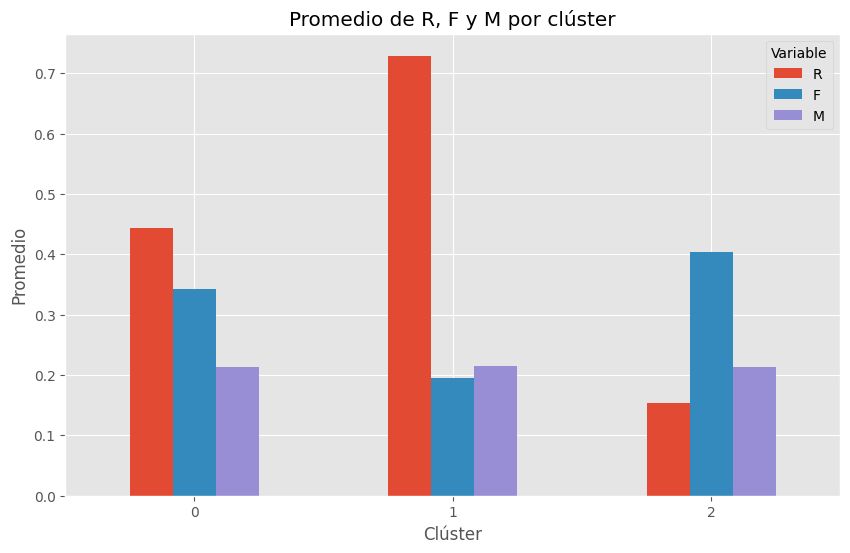

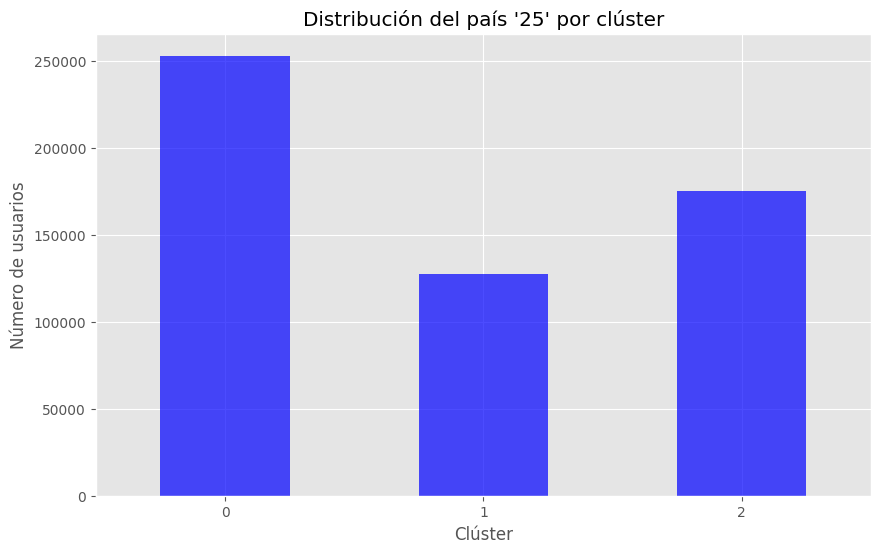


Proporción del país '25' en cada clúster (%):
cluster
0    99.278775
1    86.944783
2    99.741233
dtype: float64


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estadísticas descriptivas por clúster
cluster_stats = optimized_users_df.groupby('cluster')[['R', 'F', 'M']].describe()
print("Estadísticas descriptivas por clúster:")
print(cluster_stats)

# Promedios por clúster
cluster_means = optimized_users_df.groupby('cluster')[['R', 'F', 'M']].mean()
print("\nPromedios por clúster:")
print(cluster_means)

# Gráficos de barras para comparar promedios
cluster_means.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Promedio de R, F y M por clúster")
plt.xlabel("Clúster")
plt.ylabel("Promedio")
plt.legend(title="Variable")
plt.show()

# Representación del país "25" en cada clúster
country_cluster_distribution = optimized_users_df[optimized_users_df['country'] == 25].groupby('cluster').size()
total_cluster_distribution = optimized_users_df.groupby('cluster').size()
proportion_country_25 = (country_cluster_distribution / total_cluster_distribution) * 100

# Gráfico de barras apiladas para la representación del país "25"
country_cluster_distribution.plot(
    kind='bar',
    figsize=(10, 6),
    stacked=True,
    color=['blue'],
    alpha=0.7
)
plt.title("Distribución del país '25' por clúster")
plt.xlabel("Clúster")
plt.ylabel("Número de usuarios")
plt.xticks(rotation=0)
plt.show()

# Imprimir proporciones
print("\nProporción del país '25' en cada clúster (%):")
print(proportion_country_25)


## Correccion dataset.

In [29]:
optimized_users_df.columns

Index(['user_id', 'country', 'R', 'F', 'M', 'cluster', 'is_top_1'], dtype='object')

In [30]:
# Eliminar las columnas 'cluster' e 'is_top_1'
optimized_users_df = optimized_users_df.drop(columns=['cluster', 'is_top_1'])

# Verificar que las columnas se hayan eliminado
print(optimized_users_df.columns)

Index(['user_id', 'country', 'R', 'F', 'M'], dtype='object')


## Guardado del dataset procesado


In [31]:
# Guardar el DataFrame optimizado
optimized_users_df.to_parquet('/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/optimized_users_transformed.parquet', index=False)
print("El DataFrame optimizado ha sido guardado como 'optimized_users_transformed.parquet'.")


El DataFrame optimizado ha sido guardado como 'optimized_users_transformed.parquet'.


## Resumen

### **Resumen General del Análisis y Procedimientos Realizados con el DataFrame `user_details`**

Hemos llevado a cabo un análisis exhaustivo y transformaciones importantes en el conjunto de datos `user_details` para prepararlo de cara a su integración con otros conjuntos de datos y modelos predictivos. A continuación, detallo cada uno de los pasos realizados:

---

### **1. Carga y Limpieza Inicial**
- **Formato de los datos**:
  - El archivo estaba en formato JSON con valores anidados (listas) para las variables `country`, `R`, `F` y `M`.
  - Detectamos registros con múltiples valores en estas variables.

- **Expansión de registros**:
  - Expandimos las filas con múltiples valores en `country`, `R`, `F` y `M` para crear un registro único por combinación de valores.

---

### **2. Optimización del DataFrame**
- **Tipos de datos**:
  - Optimizamos los tipos de datos para reducir el uso de memoria:
    - `user_id` → `int32`.
    - `country` → `int8`.
    - `R` y `F` → `int16`.
    - `M` → `float32`.

- **Uso de memoria**:
  - Reducimos significativamente el uso de memoria, de más de 21 MB a solo 9.4 MB.

---

### **3. Tratamiento de Valores Atípicos**
- Detectamos valores atípicos en la variable `M` (valor monetario) mediante el método de percentiles (99%).
- Realizamos una transformación logarítmica para estabilizar la varianza y reducir la influencia de valores extremos.

---

### **4. Normalización y Escalado**
- Transformamos las variables `R`, `F` y `M`:
  - Aplicamos logaritmos a `R` y `F` para ajustar sus distribuciones.
  - Escalamos todas las variables (`R`, `F`, `M`) a un rango de [0, 1] mediante Min-Max Scaling.
- Resultados:
  - Las variables ahora están en un rango uniforme, adecuadas para su uso en modelos de aprendizaje automático.

---

### **5. Análisis Exploratorio**
#### **Distribución General de las Variables**
- **R** (Recency): 
  - Los usuarios están mayormente concentrados en valores bajos, indicando interacciones recientes.
- **F** (Frequency):
  - Hay una gran mayoría de usuarios con interacciones poco frecuentes, con algunos altamente activos.
- **M** (Monetary):
  - Tras la transformación logarítmica, la distribución es más uniforme, pero existen usuarios con altos valores monetarios.

#### **Análisis del Top 1% vs Resto**
- Identificamos los usuarios en el top 1% de valor monetario (`M`).
- Comparativa entre el top 1% y el resto:
  - El top 1% tiene un comportamiento distinto, con valores más altos en `R` y `F`.
  - Esto indica que estos usuarios no solo gastan más, sino que también son más recientes y frecuentes en sus interacciones.

#### **Segmentación de Usuarios con K-Means**
- Aplicamos un algoritmo de **k-means** con 3 clústeres.
- **Resultados por clúster**:
  - **Cluster 0**: Usuarios moderadamente recientes con interacciones frecuentes.
  - **Cluster 1**: Usuarios más antiguos y con menor actividad.
  - **Cluster 2**: Usuarios recientes y altamente activos.

#### **Distribución por País**
- El país "25" domina los registros en todos los clústeres (86%-99%).
- Esta sobrerrepresentación podría generar sesgos en futuros modelos si no se considera adecuadamente.

---

### **6. Preparación Final del DataFrame**
- Seleccionamos las variables finales (`user_id`, `country`, `R`, `F`, `M`) normalizadas.
- Añadimos el número de clúster como una nueva columna, útil para modelos predictivos.
- Optimizamos nuevamente los tipos de datos.

---

### **7. Visualización y Comparación**
- Generamos visualizaciones clave:
  - Distribuciones de `R`, `F` y `M` (antes y después de transformaciones).
  - Comparación de estadísticas del Top 1% vs el resto.
  - Promedios de `R`, `F` y `M` por clúster.
  - Proporción del país "25" en cada clúster.
- Estas visualizaciones destacaron patrones y diferencias significativas entre grupos de usuarios.